# Thomas-Fermi Capacitance Model

The aim of this notebook is to present capcitance model calculations from a Thomas-Fermi approach for islands and use the capacitance model for transport calculations. 

In [234]:
# ThomasFermi class for electron density calculations

import mpmath
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

class ThomasFermi():
    '''
    Thomas-Fermi routines based on the polylog function approach.
    '''
    def __init__(self,physics):
        '''
        physics is a dict with the revelant physics
        
        x : linspace
        V_x : potential profile
        K_0 : strength of the Coulomb interaction
        mu : chemical potential (assumed to be equal for both leads)
        '''
       
        self.physics = physics
        self.K_mat = self.calc_K_mat()

    def calc_K_mat(self):
        x = self.physics['x']
        K_0 = self.physics['K_0']
        
        dx = np.sqrt((x - x[:,np.newaxis])**2 + 1)
        return K_0/dx

    def calc_n(self):
        V = self.physics['V_x']
        K_mat = self.K_mat
        
        def f(x):
            np_polylog = np.frompyfunc(mpmath.polylog, 2, 1)
            output = -1e-2*np_polylog(1,-np.exp(50*x))
            # cast from mpc array to numpy array
            return np.array(list(map(lambda x : complex(x),output)))
        
        n = np.zeros(len(V))
        n_prev = np.zeros(len(V))
        phi = np.zeros(len(V))
        for i in range(500):
            # turn on the Coulomb over 10 steps
            if i < 10:
                phi = (i/10) * np.dot(K_mat,n)
            n_prev = n
            n = f(mu - V - phi)

            if (i > 10) and (np.linalg.norm(n - n_prev)**2 < (1e-12) * np.linalg.norm(n) * np.linalg.norm(n_prev)):
                #print("Done in",i)
                break;
        self.n = np.real(n)
        return self.n

    def calc_islands(self):
      
        n = self.n
        # adaptive eps makes the calculation more robust 
        n_eps = 3e-1*np.max(n)
        
        n_chop = np.array([x if x > n_eps else 0.0 for x in n])
        islands = {}
        start = False
        islands_index = 0
        left = 0
        for i in range(len(n_chop)):
            if(n_chop[i] > 0.0 and not start):
                start = True
                left = i
            if(n_chop[i] == 0.0 and start):
                start = False
                islands[islands_index] = [left,i - 1]
                islands_index += 1
            if((i == (len(n_chop) - 1)) and start):
                start = False
                islands[islands_index] = [left,i]
                islands_index += 1
        
        # ignore the leads
        try:
            lead1 = 0
            lead2 = len(islands) - 1
            islands.pop(lead1)
            islands.pop(lead2)
            self.islands = islands 
        except KeyError as e:
            self.islands = islands
            #raise e
        
        self.islands = islands
        return self.islands

    def calc_charges(self):
        n = self.n
        islands = self.islands
        
        charges = []
        for key,item in islands.items():
            charges.append(np.sum(n[item[0]:item[1]]))

        return np.array(charges)

    def calc_cap_model(self):
        islands = self.islands
        n = self.n

        # list of charge densities for islands
        n_list = []
        for key,item in islands.items():
            n_island = np.zeros(len(n))
            n_island[item[0]:item[1]] = n[item[0]:item[1]] 
            n_list.append(n_island)
            
        V = self.physics['V_x']
        mu = self.physics['mu']
        def cap_func(i,j):
            energy = 0.0
            if i == j:
                energy += 5*np.sum(n_list[i]*n_list[i]) + np.sum((V - mu)*n_list[i])

            energy += 2*np.dot(np.dot(n_list[i].T,self.K_mat),n_list[j])
            return energy

        # Seriously? I did not even normalise by Z_i^2 and Z_i*Z_j
        energy_matrix = np.array([cap_func(i,j) for i in range(len(n_list)) for j in range(len(n_list))])\
        .reshape((len(n_list),len(n_list)))

        # A problem here is that Z could be zero
        Z = self.calc_charges() + 1e-2
        # newaxis trick is used to calculate the outer product
        inverse_cap_matrix = 2*energy_matrix/np.dot(Z[:,np.newaxis],Z[np.newaxis])
        
        cap_model = (Z,inverse_cap_matrix)
        self.cap_model = cap_model
        
        return self.cap_model 

    def calc_cap_energy(self,N_vec):
        N_vec = np.array(N_vec)
        cap_model = self.cap_model
        return 0.5*np.dot(np.dot((N_vec-cap_model[0]),cap_model[1]),(N_vec-cap_model[0]).T)

    def calc_stable_charge_config(self):
        '''
        Full routine
        
        '''
        self.calc_n()
        self.calc_islands()
        self.calc_cap_model()
        
        (Z,inverse_cap_matrix) = self.cap_model 

        N_int = [int(x) for x in Z]
        dN_list = [range(max(0,x-2),x+2,1) for x in N_int] 
        import itertools
        N_list = list(itertools.product(*dN_list))

        energy_table = [self.calc_cap_energy(np.array(x)) for x in N_list]
        min_energy = min(energy_table)
        charge_configuration = N_list[energy_table.index(min_energy)]
        self.charge_configuration = np.array(charge_configuration)

        return self.charge_configuration

    def calc_state_current(self):
        '''
        Current and Charge calculation using a Master equation approach
        '''
        self.calc_n()
        self.calc_islands()
        self.calc_cap_model()
        
        (Z,inverse_cap_matrix) = self.cap_model 

        N_int = [int(x) for x in Z]
        dN_list = [range(max(x-1,0),x+1,1) for x in N_int] 
        import itertools
        states = list(itertools.product(*dN_list))
       
        def fermi(E,kT):
            from scipy.special import expit
            return expit(-E/kT)
        
        def calc_weight(a,b,kT):
            N_dot = len(a)
            if list(abs(np.array(a) - np.array(b))) in [list(x) for x in list(np.eye(N_dot,dtype=np.int))]:
                U_a = self.calc_cap_energy(np.array(a))
                U_b = self.calc_cap_energy(np.array(b))
                # notice the order, calc_weight calculates the weight to go from a to b
                return fermi(U_b - U_a,kT)
            else:
                return 0.0
            
        # A : adjacency matrix between the possible states, two states are connected only by a single electron tunneling event
        kT = self.physics['kT']
        A = np.array([calc_weight(a,b,kT) for a in states for b in states])\
            .reshape((len(states),len(states)))

        M = A.T - np.diag(np.sum(A,axis=1))

        # append the normalisation condition, and drop ones of the rows of M
        M_solver = np.append(M[:-1,:],[np.ones(M.shape[0])]).reshape(M.shape)

        # RHS in the master equation solution, the last element is the prob. normalisation condition
        b = np.zeros(M.shape[0])
        b[-1] = 1
        P = np.linalg.solve(M_solver,b)
        #state = states[np.argmax(P)]

        state = np.sum(np.array([x*np.array(y) for (x,y) in zip(P,states)]),axis=0)

        # poor's man current model
        # smart trick, current is finite over kT range
        if np.any([abs(x-0.5) < 25*kT for x in P]):
            current = 1
        else:
            current = 0
        return state,current


Time 0.11654496192932129
[3 3]
[ 2.98527802  2.95417145]
(array([ 2.99527802,  2.96417145]), array([[ 0.63741325,  0.17180805],
       [ 0.17180805,  0.64171357]]))
{1: [38, 47], 2: [52, 61]}
(array([ 2.99527802,  2.96417145]), array([[ 0.63741325,  0.17180805],
       [ 0.17180805,  0.64171357]]))
[[ 1.69086143 -0.45269981]
 [-0.45269981  1.67953043]]


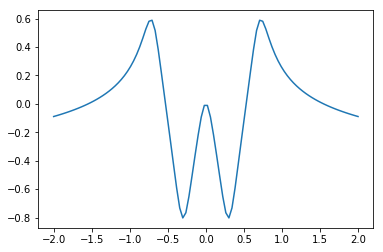

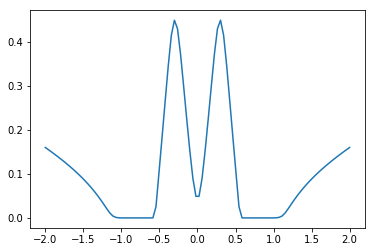

In [232]:
# calculation of the electron density for a single set of gate voltages
import sys
import time
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("/Users/sandesh/repos/quantum-ml/nanowire_model/")

import potential_profile

x = np.linspace(-2,2,100)
K_0 = 0.5e-1

def find_V(x,list_b):
    V = potential_profile.V_x_wire(x,list_b) #+ 100e-3*x**2
    return V

# gate voltages
V_0 = 650e-3
V_1 = 650e-3
def_gates = [[-500e-3,0.0,0.1,1],[-500e-3,-0.7,0.1,1],[-500e-3,0.7,0.1,1]]
list_b = def_gates + [[V_0,-0.3,0.1,1],[V_1,0.3,0.1,1]] 
V_x = find_V(x,list_b)
plt.figure(1)
plt.plot(x,V_x)

mu = 0.5

physics = {'x' : x,
           'K_0' : K_0,
           'V_x' : V_x,
           'mu'  : mu,
           'kT'  : 1e-4
}

st = time.time()
tf = ThomasFermi(physics) 
config = tf.calc_stable_charge_config()
print("Time",time.time()-st)

print(config)
plt.figure(2)
plt.plot(x,tf.n)
print(tf.calc_charges())
print(tf.cap_model)
print(tf.islands)

print(tf.cap_model)
(Z,inverse_cap_matrix) = tf.cap_model
print(np.linalg.inv(inverse_cap_matrix))

Time 1041.0492630004883


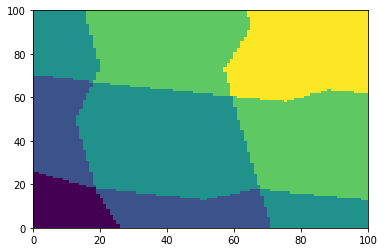

In [236]:
N_v = 100
Vd1_vec = np.linspace(400e-3,650e-3,N_v)
Vd2_vec = np.linspace(400e-3,650e-3,N_v)
# list_list_b is a list of the possible set of gate voltages which is later converted into a potential profile
list_list_b = [def_gates + [[x,-0.3,0.1,1],[y,0.3,0.1,1]] for x in Vd1_vec for y in Vd2_vec]

st = time.time()
tf = ThomasFermi(physics) 
def wrapper(V_x):
    tf.physics['V_x'] = V_x
    try:
        config = tf.calc_state_current()[0]
    #short circuit condition
    except KeyError as e: 
        config = (0)
    #print(config)
    return config

charge_config = [wrapper(find_V(x,y)) for y in list_list_b]
print("Time",time.time()-st)
plt.pcolor(np.array([np.sum(x) for x in charge_config]).reshape((N_v,N_v)))

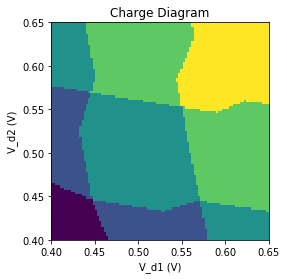

In [246]:
fig = plt.figure(2)
ax = fig.add_subplot(111)
ax.set_aspect('equal')
XX,YY = np.meshgrid(Vd1_vec,Vd2_vec)
ax.pcolor(XX,YY,np.array([np.sum(x) for x in charge_config]).reshape((N_v,N_v)))
ax.set_title("Charge Diagram")
ax.set_ylabel('V_d2 (V)')
ax.set_xlabel('V_d1 (V)')

(array([ 1.,  4.]), 0)
(array([ 1.,  4.]), 0)
(array([ 1.,  4.]), 0)
(array([ 1.,  4.]), 0)
(array([ 1.        ,  3.99999999]), 0)
(array([ 1.        ,  3.99999999]), 0)
(array([ 1.        ,  3.99999999]), 0)
(array([ 1.        ,  3.99999998]), 0)
(array([ 1.        ,  3.99999997]), 0)
(array([ 1.        ,  3.99999996]), 0)
(array([ 1.        ,  3.99999994]), 0)
(array([ 1.        ,  3.99999991]), 0)
(array([ 1.        ,  3.99999986]), 0)
(array([ 1.       ,  3.9999998]), 0)
(array([ 0.99999999,  3.9999997 ]), 0)
(array([ 0.99999998,  3.99999956]), 0)
(array([ 0.99999991,  3.99999934]), 0)
(array([ 0.9999997 ,  3.99999903]), 0)
(array([ 0.99999898,  3.99999857]), 0)
(array([ 0.99999649,  3.99999789]), 0)
(array([ 0.9999879 ,  3.99999689]), 0)
(array([ 0.99995833,  3.99999541]), 0)
(array([ 0.99985651,  3.99999323]), 0)
(array([ 0.99950606,  3.99999001]), 0)
(array([ 0.99830115,  3.99998527]), 0)
(array([ 0.99417415,  3.99997827]), 0)
(array([ 1.99999747,  3.99999998]), 0)
(array([ 1.99

(array([ 1.99998822,  2.99999091]), 0)
(array([ 1.99997513,  2.99998504]), 0)
(array([ 1.99994748,  2.99997538]), 0)
(array([ 1.99988911,  2.99995949]), 0)
(array([ 1.99976587,  2.99993333]), 0)
(array([ 2.,  3.]), 0)
(array([ 2.        ,  2.99999999]), 0)
(array([ 2.        ,  2.99999999]), 0)
(array([ 2.        ,  2.99999999]), 0)
(array([ 2.        ,  2.99999998]), 0)
(array([ 2.        ,  2.99999997]), 0)
(array([ 2.        ,  2.99999995]), 0)
(array([ 2.        ,  2.99999992]), 0)
(array([ 2.        ,  2.99999987]), 0)
(array([ 2.       ,  2.9999998]), 0)
(array([ 2.        ,  2.99999967]), 0)
(array([ 2.        ,  2.99999948]), 0)
(array([ 1.99999999,  2.99999918]), 0)
(array([ 1.99999999,  2.9999987 ]), 0)
(array([ 1.99999997,  2.99999793]), 0)
(array([ 1.99999993,  2.99999671]), 0)
(array([ 1.99999985,  2.99999478]), 0)
(array([ 1.99999966,  2.99999171]), 0)
(array([ 1.99999927,  2.99998683]), 0)
(array([ 1.9999984 ,  2.99997908]), 0)
(array([ 1.99999652,  2.99996677]), 0)
(arr

(array([ 2.99999997,  1.99999987]), 0)
(array([ 2.99999994,  1.99999974]), 0)
(array([ 2.9999999 ,  1.99999947]), 0)
(array([ 2.99999984,  1.99999892]), 0)
(array([ 2.99999972,  1.9999978 ]), 0)
(array([ 2.99999953,  1.99999552]), 0)
(array([ 2.99999919,  1.99999087]), 0)
(array([ 2.99999862,  1.99998137]), 0)
(array([ 2.99999766,  1.99996201]), 0)
(array([ 2.999996  ,  1.99992253]), 0)
(array([ 2.99999319,  1.99984203]), 0)
(array([ 2.99998839,  1.99967789]), 0)
(array([ 2.9999802 ,  1.99934333]), 0)
(array([ 3.,  2.]), 0)
(array([ 3.,  2.]), 0)
(array([ 3.,  2.]), 0)
(array([ 3.,  2.]), 0)
(array([ 3.,  2.]), 0)
(array([ 3.,  2.]), 0)
(array([ 3.        ,  1.99999999]), 0)
(array([ 3.        ,  1.99999998]), 0)
(array([ 3.        ,  1.99999997]), 0)
(array([ 3.        ,  1.99999993]), 0)
(array([ 3.        ,  1.99999987]), 0)
(array([ 3.        ,  1.99999974]), 0)
(array([ 2.99999999,  1.99999949]), 0)
(array([ 2.99999999,  1.99999899]), 0)
(array([ 2.99999998,  1.99999802]), 0)
(arr

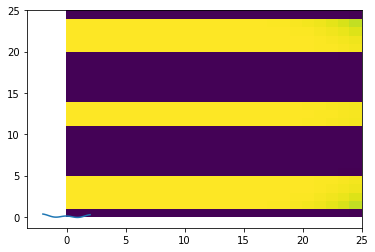

In [75]:
import sys
import time

sys.path.append("/Users/sandesh/repos/quantum-ml/nanowire_model/")

import potential_profile
def find_V(x,lever):
    V = 10e-2*np.cos(np.pi*x) + 5e-2*x**2 + lever*x
    return V


mu = 0.00  
x = np.linspace(-2,2,100)
K_0 = 0.1e-2

physics = {'x' : x,
           'K_0' : K_0,
           'mu'  : mu,
           'kT'  : 1e-2
}
plt.figure(1)
lever = -20e-3
plt.plot(x,find_V(x,lever))

tf = ThomasFermi(physics)
tf.physics['V_x'] = find_V(x,lever)

result = tf.calc_state_current()
print(result)

N_v = 25
b = np.linspace(-20e-3,20e-3,N_v)
mu_vec = np.linspace(0,0.1,N_v)
charge = []
for y in b:
    for z in mu_vec:
        tf.physics['V_x'] = find_V(x,y)
        tf.physics['mu'] = z 
        result = tf.calc_state_current()
        charge += [np.sum(result[0])]
        print(result)

plt.pcolor(np.array(charge).reshape((N_v,N_v)))

Time 1.493027925491333
[]
[]
(array([], dtype=float64), array([], shape=(0, 0), dtype=float64))


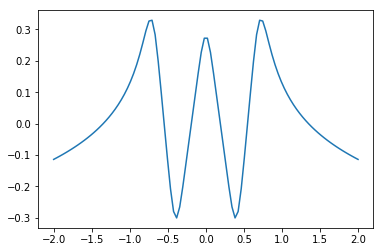

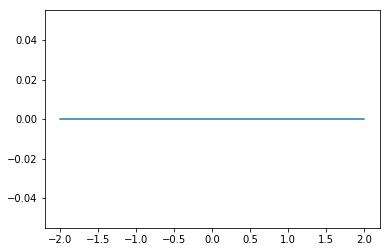

In [81]:
import sys
import time

sys.path.append("/Users/sandesh/repos/quantum-ml/nanowire_model/")

import potential_profile

x = np.linspace(-2,2,100)
K_0 = 0.5e-1

def find_V(x,list_b):
    V = potential_profile.V_x_wire(x,list_b) #+ 100e-3*x**2
    return V

# gate voltages
V_0 = 350e-3
V_1 = 350e-3
def_gates = [[-300e-3,0.0,0.1,1],[-300e-3,-0.7,0.1,1],[-300e-3,0.7,0.1,1]]
list_b = def_gates + [[V_0,-0.4,0.1,1],[V_1,0.4,0.1,1]] 
V_x = find_V(x,list_b)
plt.figure(1)
plt.plot(x,V_x)

mu = 0.2  

physics = {'x' : x,
           'K_0' : K_0,
           'V_x' : V_x,
           'mu'  : mu,
           'kT'  : 1e-4
}

st = time.time()
tf = ThomasFermi(physics) 
config = tf.calc_stable_charge_config()
print("Time",time.time()-st)

print(config)
plt.figure(2)
plt.plot(x,tf.n)
print(tf.calc_charges())
print(tf.cap_model)



In [90]:
max(0,-1)

0